In [57]:
import pandas as pd
import numpy as np
from pycox.datasets import support
from sksurv import nonparametric
from lifelines import KaplanMeierFitter, CoxPHFitter
import matplotlib.pyplot as plt
import collections
from sksurv.linear_model import CoxnetSurvivalAnalysis
from sksurv.datasets import load_breast_cancer, load_veterans_lung_cancer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer

In [58]:
pre_inicu_df = pd.read_csv("pre_inicu_1d.csv").drop(columns = ["Unnamed: 0"])
newdf = pd.read_csv("ich_v1.csv").drop(columns = ["Unnamed: 0"])
newdf["ethnic"] = newdf["ethnic"].fillna(newdf["ethnic"].mode()[0]) # Fill every NA with white
newdf = newdf[newdf["age_at_admit"] < 200]

In [59]:
newdf["gender"] = newdf["gender"].map({'m':'m',
                     'f':'f',
                     'thnicity:black/cape verdea':'m',  
                     'thnicity:hispanic/latino - puerto rica':'m',
                     'thnicity:oth':'m',
                     'thnicity:whit':'m','thnicity:asian - vietnames':'m'})

In [60]:
df = pd.read_csv("/Users/lerdp/Desktop/ich_topicmodeling/ich_preprocess.csv", sep = ",")

In [61]:
# TODO: Group marital status into married and not married (Done: Filled with majority 80 missing)
# TODO: Group insurance government, medicare, medicaid to government (Done: No missing)
# TODO: Emergency room and non emergency room (Done: No missing)
# TODO: Drop religion Done
death = ["death_in_icu"]
not_needed = ["inicu_time","outicu_time","deceased_time"]
marital = ["chart:marital status:",
    'marital_status:divorced',
             'marital_status:married',
             'marital_status:na',
             'marital_status:separated',
             'marital_status:single',
             'marital_status:unknown (default)',
             'marital_status:widowed']
GI = ['insurance:government','insurance:medicaid','insurance:medicare']
non_GI = ["insurance:private", "insurance:self pay"]
admit = ['admission_location:clinic referral/premature',
     'admission_location:emergency room admit',
     'admission_location:phys referral/normal deli',
     'admission_location:transfer from hosp/extram',
     'admission_location:transfer from other healt',
     'admission_location:transfer from skilled nur']
religion = ["religion"]
not_needed += (marital + GI + non_GI + admit + religion + death)
newdf["isMarried"] = newdf['marital_status:married'].fillna(0)
newdf["isGI"] = newdf[GI].fillna(0).sum(axis=1)
newdf["isEmergency"] = newdf['admission_location:emergency room admit'].fillna(0)
newdf = newdf.drop(columns = not_needed)

In [62]:
def findNIHSS(pre_inicu_df, pt):
    # @param pre_inicu_df: A dataframe we want to calculate NIHSS score from
    # @param pt: Patient ID
    pass

def extractFromDict(dictionary, key_lst):
    """
    @param dictionary: A dictionary we want to extract info from
    @param key_lst: List of keys 
    Return: A list of key values according to dictionary
    """
    lst = []
    value = None
    for key in key_lst:
        try:
            value = dictionary[key]
        except:
            value = None
        lst.append(value)
    return lst

def displayStatistics(event_name, event_dict, newdf, title = "", xlabel = "", ylabel = ""):
    # Display death statistics per different types of event and create the boxplot for length of stay
    tempdf = pd.DataFrame(index = newdf["pt"].tolist(), columns = [event_name, "N", 
                                                                   "death_in_icu","days_in_icu"])
    tempdf[event_name] = extractFromDict(event_dict, tempdf.index.tolist())
    tempdf["days_in_icu"] = newdf["days_in_icu"].tolist()
    tempdf["death_in_icu"] = newdf["death_in_icu"].tolist()
    
    # Display death statistics and average days_in_icu
    display_df = pd.DataFrame(columns = tempdf.columns.tolist())
    by_death = tempdf.groupby(event_name)["death_in_icu"].agg(pd.Series.mean).sort_values(ascending = True)
    by_days = tempdf.groupby(event_name)["days_in_icu"].agg(pd.Series.mean)
    
    # Displaying summary statistics sorted by death rate, a measure of stroke severity.
    decimal = 2
    display_df[event_name] = by_death.index.tolist()
    display_df["death_in_icu"] = pd.Series(by_death.tolist()).round(decimal)
    by_days = by_days[by_death.index.tolist()].tolist()
    display_df["days_in_icu"] = pd.Series(by_days).round(decimal)
    display_df["N"] = tempdf[event_name].value_counts()[by_death.index.tolist()].tolist()
    print(display_df)
    
    # Specify columns to include
    include_col = ["days_in_icu", event_name]
    tempdf[include_col].boxplot(by = event_name, figsize = (12,8)).set_title("%s (n=%d)" %(title, tempdf.shape[0]))
    plt.xlabel(xlabel)
    plt.ylabel(ylabel) 
    
    
def displayBinarize():
    # TODO: Merge with displayStatistics
    pass


def createEventDict(df, event_name, groupbyMode = True, fillEmpty = False, fillValue = "NA"):
    """
    @df: A longitudinal dataframe for patients and events
    @event_name: Name of the event
    @groupbyMode: A Boolean variable. True = Use mode; False Use mean to perform groupBy on value. 
    @fillEmpty: If True, pad the dictionary for patients without key recorded in the data as fillValue. 
    @fillValue: See fillEmpty.  
    # Create a dictionary with patient_id as key and the mode/mean for event_name as value.
    # Usage: Create a dictionary to classify patients into different severity according to NIHSS.
             Set fillEmpty = True for padding.
    #### Limitation: Assume all encoding is properly handled (e.g. no arouse vs arouse to stimul)
    """
    tempdict = df[df["event"] == event_name]
    value_lst = []
    if groupbyMode: 
        groupby = tempdict.groupby("pt")["value"].agg(pd.Series.mode)
    else:
        tempdict["value"] = pd.to_numeric(tempdict["value"])
        groupby = tempdict.groupby("pt")["value"].agg(pd.Series.mean)
        
    # Handle the case with more than one common mode
    if groupbyMode and all(isinstance(elt, str) for elt in groupby.tolist()) == False: 
        for value in groupby.tolist():
            if isinstance(value, np.ndarray):
                value = value[np.random.randint(len(value))]
            value_lst.append(value)
    else:
        value_lst = groupby.tolist()
    key_lst = groupby.index.tolist()
    
    return_dict = dict(zip(key_lst, value_lst))
    if fillEmpty:
        # df has all of the patient IDs. Therefore, NApt is the list of patients with unavailable data.
        NApt = [pt for pt in df.drop_duplicates("pt")["pt"].tolist() if pt not in key_lst]
        fill_dict = dict(zip(NApt, np.repeat(fillValue, len(NApt))))
        return_dict.update(fill_dict)
    
    return return_dict
def getValues(dictionary):
    """
    @param dictionary: A dictionary we want to extract unique values from.
    Return: A list of unique values
    """
    return pd.Series([v for k,v in event_dict.items()]).unique()

def mapValues(original, mapper):
    temp = {}
    for k,v in original.items():
        try:
            temp[k] = mapper[v]
        except:
            temp[k] = v
    return temp

def searchStatus(df, term, toDisplay=False, toReturn=False):
    temp = df.drop_duplicates("event")["event"]
    lst = []
    for event in temp.tolist():
        if event.find(term) != -1:
            if toDisplay:
                print(event)
            lst.append(event)
    if toReturn:
        return lst

# Question 1: Translate NIHSS score to length of stay and death

# NIHSS 1A: Level of consciousness

I classified the consciousness level according to NIHSS. The trend suggests that patients who stay the longest
are those in the middle (not too severe/unresponsive and not too alert). The death proportion confirms this.

NOTE: Some levels of consciousness have unclear mapping to NIHSS (e.g., "sedated" can refer to mild/moderate/deeep sedation, each corresponding to different NIHSS-1A). 

RESOURCE:
1. Levels of sedation: https://aci.health.nsw.gov.au/networks/eci/clinical/clinical-tools/procedural-sedation-ed/procedural-sedation---levels-of-sedation
2. NIHSS calculator: https://www.mdcalc.com/nih-stroke-scale-score-nihss

In [14]:
event_name = "chart:level of consciousness:"
event_dict = createEventDict(df, event_name, groupbyMode = True, fillEmpty = True, fillValue = "NA")
mapper = {"Alert": "Alert",
          'Arouse to Voice': "Arouse", 
          'Arouse to Stimul': "Arouse",
          'Arouse to Stimulation': "Arouse",
          "Lethargic":"Pain",
          "Sleeping":"Pain",
          "Dozing Intermit":"Pain",
          "Arouse to Pain": "Pain",
          "Sedated":"Pain",
          'Awake/Unresponsive':"Unresponsive",
          "Other/Remarks":"NA",
          "Paralytic Med":"NA"
          }
event_dict = mapValues(event_dict, mapper)

In [15]:
displayStatistics(event_name, event_dict, newdf)

KeyError: 'death_in_icu'

# NIHSS 1B: Month and Age

In [ ]:
dysarthria = df[df["event"] == "codx:dysarthria"]["pt"].tolist()
aphasia = df[df["event"] == "codx:aphasia"]["pt"].tolist()
all_dict = {}
dict_1 = dict(zip(dysarthria, np.repeat(1,len(dysarthria))))
dict_2 = dict(zip(aphasia, np.repeat(1,len(aphasia))))

# Use Glascow as a proxy
event_name = "chart:gcs - verbal response:"
tempdf = df[df["event"] == event_name].groupby(["pt"])["value"].agg(pd.Series.mode)
dict_gcs = {}
for pt in tempdf.index:
    response = tempdf[pt]
    if len(response) <= 3: # Only one mode
        response = response[np.random.randint(len(response))]
    # Match with GCS: Verbal
    if response == "Oriented":
        dict_gcs[pt] = 0
    elif response == "Inappropriate Words" or response == "Confused": # 4-3 of GCS
        dict_gcs[pt] = 1
    else: # 1-2 of GCS
        dict_gcs[pt] = 2
        
all_dict.update(dict_1)
all_dict.update(dict_2)
all_dict.update(dict_gcs)

In [16]:
displayStatistics("NIHSS_1b and NIHSS_10", all_dict, newdf, title="NIHSS1b")

NameError: name 'all_dict' is not defined

# NIHSS 1C:  'Blink eyes' & 'squeeze hands'

Only blink eyes is available.

In [ ]:
event_name = "chart:eye opening:"
event_dict = createEventDict(pre_inicu_df, event_name, groupbyMode = True, fillEmpty = True, fillValue = "NA")
displayStatistics(event_name, event_dict, newdf)

# GCS Coma Score

I binarized GCS scores into 10 bins and plot how many are dead. 

In [ ]:
tempdf = df[df["event"] == event_lst[0]]
tempdf = tempdf[tempdf["pt"].isin(newdf["pt"].tolist())]
tempdf["value"] = pd.to_numeric(tempdf["value"])
gcs = tempdf.groupby("pt")["value"].agg(pd.Series.mean)

In [ ]:
copy = newdf.copy()
days_lst = copy[copy["pt"].isin(gcs.index)]["days_in_icu"].tolist()
gcs_lst = gcs.tolist()
gcsdf = pd.DataFrame(columns = ["pt","death_in_icu","days_in_icu","gcs"])
gcsdf["days_in_icu"] = days_lst
gcsdf["gcs"] = gcs_lst
gcsdf["death_in_icu"] = copy[copy["pt"].isin(gcs.index)]["death_in_icu"]
gcsdf["pt"] = gcs.index.tolist()
gcsdf

In [ ]:
nbin = 10
bintick = np.linspace(0,1,num=nbin+1, endpoint=True)
binlabel = ["%sQ" %(str(i+1)) for i in range(nbin)]
quartiles = gcsdf["gcs"].quantile(bintick).tolist()
gcsdf["quartiles"] = pd.cut(gcsdf["gcs"], bins = quartiles, labels = binlabel)
mean_lst = []

for i in range(nbin):
    days = np.mean(gcsdf[gcsdf["quartiles"] == str(i+1)+"Q"]["days_in_icu"])
    mean_lst.append(days)
ax, fig = plt.subplots(figsize = (12,8))
plt.plot(np.arange(1,nbin+1,1), mean_lst, "*--")
plt.xlabel("Quartiles of Glascow Coma Score")
plt.ylabel("Length of stay")
plt.title("Plots on length of stay per gcs")


In [ ]:
for i in range(1,11):
    qname = "%sQ" %(str(i))
    prop_death = gcsdf[gcsdf["quartiles"] == qname]["death_in_icu"].mean()
    print("%d: Death prop = %f" %(i,prop_death))

# NIHSS 3-11

## NIHSS3: Visual

Few co-diagnostics related to visual status exist, namely visual codx disturbances and codx:visual field defect.
I used the first term: "chart:visual / hearing deficit:" as a proxy (n = 199).

## NIHSS4: Facial Palsy

In [ ]:
event_lst = searchStatus(df, "visual", toReturn = True)
event_name = event_lst[0]
event_dict = createEventDict(pre_inicu_df, event_name, groupbyMode = True, fillEmpty=True)
displayStatistics(event_name, event_dict, newdf)

In [ ]:
# NIHSS 5/6 A/B: Left arm motor drift
event_lst = searchStatus(df, "drift", toReturn = True)
event_name = event_lst[0]
event_dict = createEventDict(pre_inicu_df, event_name, groupbyMode = True, fillEmpty = True, fillValue = "NA")
displayStatistics(event_name, event_dict, newdf)

In [ ]:
# NIHSS 7 Limb ataxia (NA): No chart recording of limb ataxia. Only comorbidity is encoded
# NIHSS 8 Sensation
event_lst = searchStatus(df, "sens", toReturn = True)
event_name = "chart:braden sensory perception:"
event_dict = createEventDict(pre_inicu_df, event_name, groupbyMode = True, fillEmpty = True, 
                             fillValue = "NA")

for key in list(event_dict.keys()):
    if event_dict[key] == "Comp. Limited":
        event_dict[key] = "Completely Limited"
    elif event_dict[key] == "Sl. Limited":
        event_dict[key] = "Slight Impairment"
        
displayStatistics(event_name, event_dict, newdf)

In [ ]:
# NIHSS 9: Language responsse
event_lst = searchStatus(df, "verbal", toDisplay = False, toReturn = True)
event_name = event_lst[0]
event_dict = createEventDict(pre_inicu_df, event_name, groupbyMode = True, fillEmpty = False, 
                             fillValue = "No")

for key in list(event_dict.keys()):
    if event_dict[key] == "1.0 ET/Trach":
        event_dict[key] = "1 No Response"
    elif event_dict[key] == '3 Inapprop words':
        event_dict[key] = '2 Incomp sounds'

displayStatistics(event_name, event_dict, newdf)

In [ ]:
# NIHSS 11: Extinction/inattention
event_lst = searchStatus(df, "inattention", toReturn = True)
event_name = event_lst[0]

event_dict = createEventDict(pre_inicu_df, event_name, groupbyMode = True, fillEmpty = False, 
                             fillValue = "NA")
for key in list(event_dict.keys()):
    if event_dict[key].lower().find("no") != -1:
        event_dict[key] = "no"
    elif event_dict[key].lower().find("yes") != -1:
        event_dict[key] = "yes"
displayStatistics(event_name, event_dict, newdf)

# Displaying summary statistics of comorbidity

# Cox regression

In [17]:
newdf =  pd.get_dummies(newdf, drop_first = True)
# include_col = ["gender_m"] + ["days_in_icu", "fully_observed"]
# temp = temp[include_col]
cph = CoxPHFitter()
cph.fit(newdf, "days_in_icu", "fully_observed")
cph.print_summary()

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/lifelines/utils/printer.py:62: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  return summary_df[columns].to_latex(float_format="%." + str(self.decimals) + "f")


<lifelines.CoxPHFitter: fitted with 956 total observations, 206 right-censored observations>
             duration col = 'days_in_icu'
                event col = 'fully_observed'
      baseline estimation = breslow
   number of observations = 956
number of events observed = 750
   partial log-likelihood = -4348.96
         time fit was run = 2022-07-05 17:18:42 UTC

---
                coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                             
pt              0.00       1.00       0.00             0.00             0.00                 1.00                 1.00
age_at_admit    0.01       1.01       0.00             0.00             0.02                 1.00                 1.02
isMarried       0.04       1.04       0.08            -0.11             0.19                 0.89                 1.20
isGI           -0.09       0.91       0.10            -0.28             0.10                 0.76                 1.11
isEmergency     0.11       1.11       0.09            -0.07             0.28                 0.93                 1.33
ethnic_black   -0.23       0.80       0.24            -0.69             0.24                 0.50                 1.27
ethnic_latino   0.11       1.12       0.27            -0.42             0.64                 0.66                 1.90
ethnic_other   -0.20       0.82       0.26            -0.70             0.31                 0.50                 1.36
ethnic_white   -0.02       0.98       0.20            -0.41             0.38                 0.66                 1.46
gender_m        0.01       1.01       0.08            -0.14             0.16                 0.87                 1.17

                cmp to     z      p   -log2(p)
covariate                                     
pt                0.00  2.62   0.01       6.82
age_at_admit      0.00  2.83 <0.005       7.76
isMarried         0.00  0.48   0.63       0.66
isGI              0.00 -0.93   0.35       1.50
isEmergency       0.00  1.16   0.25       2.03
ethnic_black      0.00 -0.96   0.34       1.57
ethnic_latino     0.00  0.41   0.69       0.55
ethnic_other      0.00 -0.77   0.44       1.17
ethnic_white      0.00 -0.09   0.93       0.10
gender_m          0.00  0.13   0.90       0.15
---
Concordance = 0.55
Partial AIC = 8717.92
log-likelihood ratio test = 21.36 on 10 df
-log2(p) of ll-ratio test = 5.74

# Examine what tests (and how many) are taken for each patient?

## How frequent is each test taken? 

There are 54 patients with age greater than 200. Their ages are encoded as such to protect their identity. Therefore, I removed them during the pre-processing steps. 

Some events have more recordings than the first inicu.


Tests that are administered per minute are chart:heart rate:bpm (pt 54073). However, some patients (e.g. pt 12346) only have heart rate recorded on a 15-minute basis. Therefore, using variance might be a problem
- E.g., Heart rate: 90 - 89
- 90 90


There are 41,703 events out of 130k events with data completed more than 50%. I have set up the 

In [18]:
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})

In [19]:
# Remove patients with absurdly high age for both pre_inicu_df
newdf = newdf[newdf["age_at_admit"] < 200]
pre_inicu_df = pre_inicu_df[pre_inicu_df["pt"].isin(newdf["pt"].tolist())]
pre_inicu_df = pre_inicu_df[pre_inicu_df["event"] != "date of birth"]
df = df[df["pt"].isin(newdf["pt"].tolist())]

In [20]:
# Extract the list of all times per patient. Subtract all of them with the timestamp of first
# non-demographic observation. Afterwards, convert everything into an hour scale
second_per_day = 24*60*60
timestamp_per_pt = pre_inicu_df.groupby("pt")["t"].unique().apply(lambda x: (x-x[1])[1:])
timestamp_per_pt = timestamp_per_pt.apply(lambda x: np.around(x/second_per_day,8))

In [21]:
# Number of timestamps per day (x[-1] is the number of days) 
timestamp_per_pt.apply(lambda x: len(x)/x[-1]).sort_values(ascending = False)

pt
13638.0            inf
17043.0            inf
23275.0            inf
30130.0    5082.333808
32240.0    3260.355705
              ...     
6432.0        0.020234
55260.0       0.016296
90451.0       0.010840
43084.0       0.008301
53763.0       0.005725
Name: t, Length: 956, dtype: float64

In [22]:
np.diff(pre_inicu_df[pre_inicu_df["pt"]==12346].drop_duplicates("t")["t"]).tolist()

[2348300400.0,
 352380.0,
 4500.0,
 3780.0,
 1200.0,
 1920.0,
 600.0,
 2580.0,
 1440.0,
 900.0,
 600.0,
 300.0,
 900.0,
 900.0,
 900.0,
 900.0,
 900.0,
 900.0,
 1380.0,
 420.0,
 900.0,
 900.0,
 300.0,
 1500.0,
 120.0,
 780.0,
 900.0,
 1020.0,
 2580.0,
 3600.0,
 1800.0,
 1800.0,
 3600.0,
 1800.0,
 540.0,
 1260.0,
 2100.0,
 1500.0,
 60.0,
 3540.0,
 3600.0,
 3600.0,
 3600.0,
 1800.0,
 1800.0,
 3600.0,
 1740.0,
 60.0,
 1800.0,
 1800.0,
 900.0,
 900.0,
 900.0,
 900.0,
 1800.0,
 3600.0,
 60600.0,
 1020.0,
 33180.0,
 7680.0,
 44520.0,
 1800.0,
 84600.0,
 2400.0,
 81000.0,
 10800.0,
 32400.0,
 44100.0,
 1980.0,
 86520.0,
 85800.0,
 89580.0,
 81420.0,
 1380.0,
 27144720.0,
 3600.0,
 360.0,
 540.0,
 900.0,
 900.0,
 1800.0,
 3600.0,
 900.0,
 60.0,
 840.0,
 900.0,
 900.0,
 900.0,
 900.0,
 900.0,
 900.0,
 1800.0,
 1560.0,
 240.0,
 900.0,
 900.0,
 1800.0,
 3600.0,
 1800.0,
 5400.0,
 3600.0,
 3600.0,
 3600.0,
 3600.0,
 3600.0,
 1800.0,
 1800.0,
 3600.0,
 3600.0,
 3600.0,
 3600.0,
 7200.0,
 3600.0,
 3

In [ ]:
mock = pre_inicu_df[pre_inicu_df["pt"]==78948]["t"].unique().tolist()
mock = [item - mock[1] for item in mock] 
mock

In [ ]:
# How many days of observation do we have per patient?
# The histogram suggests that around 800 patients, we only observe the data for around 1.5 days before they were
# admitted to ICU (note: pre-inicu-df includes up until 1 day after admittance)
temp = pd.Series([per_pt[-1] for per_pt in timestamp_per_pt.tolist()])
plt.hist(temp.clip(upper = 4))

In [ ]:
# Check frequency for each patient. 
temp = pre_inicu_df.groupby(["event","pt"])["t"].agg(pd.Series.nunique)

In [ ]:
# Given the frequency, we check how many events were checked more frequently?
# Note: This event is run more frequently. 
# TODO: Need to account for how many days we have in advance for patient prior to ICU 
# because as of now, variables with high frequency are those that correlate with time. 

# HOW??: Idea 1: Remove outliers; Idea 2: Normalize the time per pt. 
event_summary = []
for i,event in enumerate(pre_inicu_df["event"].unique().tolist()):
    if i%10000 == 0:
        print("Running")
    count_per_pt =  temp.iloc[temp.index.get_level_values("event") == event] 
    n_pt = len(count_per_pt.tolist())
    if n_pt > 50:
        mean = count_per_pt.mean()
        std = count_per_pt.std()
        coef_var = std/mean
        event_summary.append((event, mean, std, coef_var))

In [ ]:
sort_event = sorted(event_summary, key = lambda x: x[3])
sort_event

# Add numerical variables with LASSO penalty


First, I subsetted the event with numerical values and counted how many events have complete data for more than 
half of the patients (500). There are mostly charts and some events with labs. 

In [63]:
# Coerce all events into numeric. 
# Events with value that is either NA or string will be converted to NaN and eventually removed
copy = pre_inicu_df.copy()
copy["value"] = pd.to_numeric(copy["value"], errors="coerce")
copy = copy[copy["value"].isna() == False]

In [64]:
newdf = newdf.set_index("pt")

In [65]:
# Group events by value
event_per_pt = copy.groupby(["pt","event"])["value"].agg(pd.Series.mean)

In [66]:
# Decide which events to include using how complete the observations are. 
mostly_complete = []
for event in event_per_pt.index.get_level_values("event").unique().tolist():
    groupby_event = event_per_pt.iloc[event_per_pt.index.get_level_values("event") == event]
    if groupby_event.shape[0] > newdf.shape[0]/2:
        mostly_complete.append(event)

In [67]:
# Add elements in the mostly complete to the dataframe
for event in mostly_complete:
    per_event = event_per_pt.iloc[event_per_pt.index.get_level_values("event") == event]
    pt_lst = [pt for pt, event in per_event.index.tolist()]
    value_lst = per_event.tolist()
    event_dict = dict(zip(pt_lst, value_lst))
    newdf[event] = extractFromDict(event_dict, newdf.index.tolist())

In [68]:
backup = newdf.copy()
newdf_simp = newdf.drop(columns = ["days_in_icu","fully_observed"]).copy()
newdf_iter = newdf_simp.copy()
pre_iter_col = newdf_iter.columns.tolist()

In [70]:
newdf_simp.to_csv("for_lc.csv")

In [30]:
imp_simple = SimpleImputer(missing_values =np.nan, strategy='mean')
lr = LinearRegression()
imp_iter = IterativeImputer(estimator=lr,missing_values=np.nan, max_iter=10, verbose=2, 
                            imputation_order='roman', random_state=0)

In [31]:
newdf_simp = imp_simple.fit_transform(newdf_simp)
newdf_iter = imp_iter.fit_transform(newdf_iter)

[IterativeImputer] Completing matrix with shape (956, 37)
[IterativeImputer] Ending imputation round 1/10, elapsed time 0.12
[IterativeImputer] Change: 81.80112312173836, scaled tolerance: 0.914 
[IterativeImputer] Ending imputation round 2/10, elapsed time 0.23
[IterativeImputer] Change: 37.54200063582136, scaled tolerance: 0.914 
[IterativeImputer] Ending imputation round 3/10, elapsed time 0.34
[IterativeImputer] Change: 9.248027760973358, scaled tolerance: 0.914 
[IterativeImputer] Ending imputation round 4/10, elapsed time 0.44
[IterativeImputer] Change: 4.146674791611179, scaled tolerance: 0.914 
[IterativeImputer] Ending imputation round 5/10, elapsed time 0.63
[IterativeImputer] Change: 3.065252542241333, scaled tolerance: 0.914 
[IterativeImputer] Ending imputation round 6/10, elapsed time 0.77
[IterativeImputer] Change: 2.668911506152713, scaled tolerance: 0.914 
[IterativeImputer] Ending imputation round 7/10, elapsed time 0.88
[IterativeImputer] Change: 2.32809454180067, sc

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/impute/_iterative.py:700: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [32]:
# Calculate unweighted distance between both types of imputations 
sse = 0
for i, pt in enumerate(newdf_simp):
    pt_simp = pt
    pt_iter = newdf_iter[i]
    difference_array = np.subtract(pt_simp, pt_iter)
    squared_array = np.square(difference_array)
    mse = squared_array.mean()
    sse += mse

In [33]:
# Afterwards, fit the Cox regression
newdf_simp = pd.DataFrame(newdf_simp, columns = pre_iter_col)
newdf_simp["days_in_icu"] = newdf["days_in_icu"].tolist()
newdf_simp["fully_observed"] = newdf["fully_observed"].tolist()

In [34]:
# Identify columns to include
low_var = ["inicu"]
for col in newdf_simp.columns.tolist():
    if newdf[col].var() < 0.01:
        low_var.append(col)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/autograd/tracer.py:48: RuntimeWarning: overflow encountered in multiply
  return f_raw(*args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/autograd/tracer.py:48: RuntimeWarning: invalid value encountered in multiply
  return f_raw(*args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/autograd/core.py:213: RuntimeWarning: invalid value encountered in add
  def _mut_add(self, x, y):    x += y; return x
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/autograd/core.py:213: RuntimeWarning: overflow encountered in add
  def _mut_add(self, x, y):    x += y; return x
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/lifelines/utils/safe_exp.py:92: RuntimeWarning: overflow encountered in multiply
  return lambda g: g * ans
/Library/Frameworks/Python.framework/Versions/

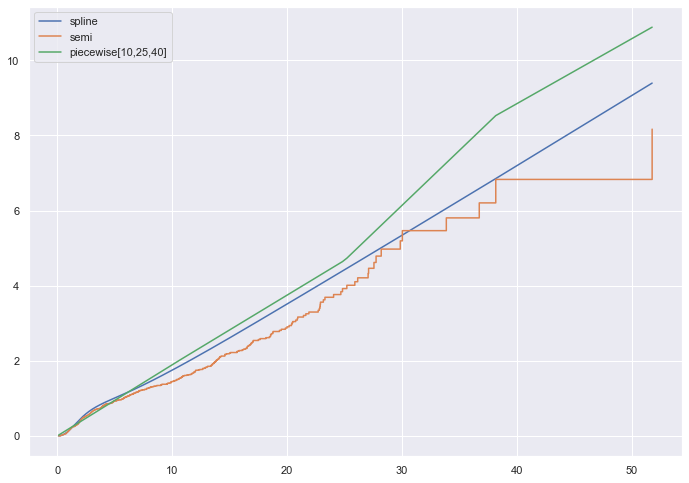

In [35]:
# Display baseline function
temp_dataset = newdf_simp.drop(columns = low_var)
cph_semi = CoxPHFitter(penalizer=0.01, l1_ratio=1.0)
cph_spline = CoxPHFitter(baseline_estimation_method="spline",  n_baseline_knots=4)
cph_piecewise = CoxPHFitter(baseline_estimation_method="piecewise", breakpoints=[10, 25, 40])

cph_semi.fit(temp_dataset, 
        duration_col = "days_in_icu", 
        event_col = "fully_observed")
cph_spline.fit(temp_dataset, 
              duration_col = "days_in_icu", 
              event_col = "fully_observed")
cph_piecewise.fit(temp_dataset, 
              duration_col = "days_in_icu", 
              event_col = "fully_observed")

bch_key = "baseline cumulative hazard"
ax = cph_spline.baseline_cumulative_hazard_[bch_key].plot(label="spline")
cph_semi.baseline_cumulative_hazard_[bch_key].plot(ax=ax, drawstyle="steps-post", label="semi")
cph_piecewise.baseline_cumulative_hazard_[bch_key].plot(ax=ax, label="piecewise[10,25,40]")
plt.legend()

In [36]:
cph_semi.print_summary()

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/lifelines/utils/printer.py:62: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  return summary_df[columns].to_latex(float_format="%." + str(self.decimals) + "f")


<lifelines.CoxPHFitter: fitted with 956 total observations, 206 right-censored observations>
             duration col = 'days_in_icu'
                event col = 'fully_observed'
                penalizer = 0.01
                 l1 ratio = 1.0
      baseline estimation = breslow
   number of observations = 956
number of events observed = 750
   partial log-likelihood = -4324.78
         time fit was run = 2022-07-05 17:44:49 UTC

---
                                         coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                                      
age_at_admit                             0.01       1.01       0.00             0.00             0.01                 1.00                 1.02
isMarried                                0.02       1.02       0.08            -0.12             0.17                 0.88                 1.19
isGI                                    -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
isEmergency                              0.04       1.04       0.08            -0.12             0.20                 0.88                 1.22
ethnic_black                            -0.22       0.80       0.15            -0.51             0.07                 0.60                 1.07
ethnic_latino                            0.09       1.09       0.21            -0.32             0.49                 0.72                 1.64
ethnic_other                            -0.05       0.95       0.17            -0.38             0.29                 0.68                 1.34
ethnic_white                             0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
gender_m                                 0.03       1.03       0.08            -0.14             0.19                 0.87                 1.21
lab:blood:chemistry:anion gap           -0.02       0.98       0.02            -0.06             0.01                 0.95                 1.01
lab:blood:chemistry:bicarbonate          0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
lab:blood:chemistry:chloride            -0.00       1.00       0.02            -0.03             0.03                 0.97                 1.03
lab:blood:chemistry:creatinine          -0.10       0.90       0.05            -0.21             0.00                 0.81                 1.00
lab:blood:chemistry:glucose             -0.00       1.00       0.00            -0.00            -0.00                 1.00                 1.00
lab:blood:chemistry:potassium            0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
lab:blood:chemistry:sodium              -0.01       0.99       0.02            -0.05             0.02                 0.95                 1.02
lab:blood:chemistry:urea nitrogen        0.00       1.00       0.01            -0.01             0.01                 0.99                 1.01
lab:blood:hematology:basophils           0.43       1.54       0.15             0.13             0.73                 1.14                 2.08
lab:blood:hematology:eosinophils         0.02       1.02       0.04            -0.05             0.10                 0.95                 1.10
lab:blood:hematology:hematocrit          0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
lab:blood:hematology:hemoglobin          0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
lab:blood:hematology:inr(pt)            -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
lab:blood:hematology:lymphocytes         0.00       1.00       0.00            -0.00             0.00    

<AxesSubplot:>

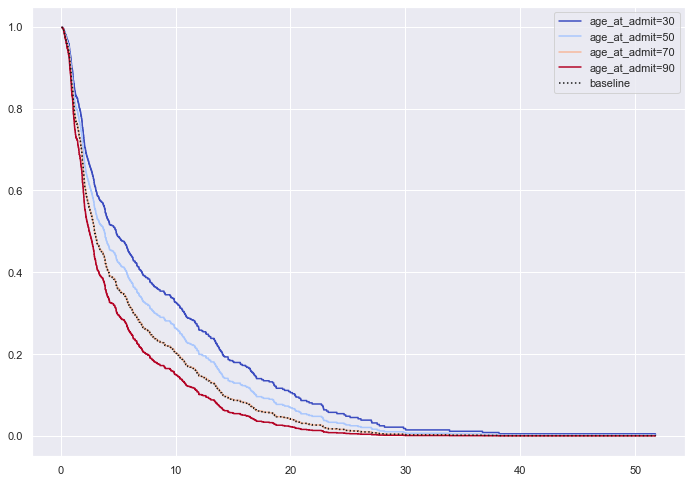

In [37]:
cph_semi.plot_partial_effects_on_outcome(covariates='age_at_admit', values=[30,50,70,90], cmap='coolwarm')

In [38]:
cph_semi.print_summary()

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/lifelines/utils/printer.py:62: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  return summary_df[columns].to_latex(float_format="%." + str(self.decimals) + "f")


<lifelines.CoxPHFitter: fitted with 956 total observations, 206 right-censored observations>
             duration col = 'days_in_icu'
                event col = 'fully_observed'
                penalizer = 0.01
                 l1 ratio = 1.0
      baseline estimation = breslow
   number of observations = 956
number of events observed = 750
   partial log-likelihood = -4324.78
         time fit was run = 2022-07-05 17:44:49 UTC

---
                                         coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                                      
age_at_admit                             0.01       1.01       0.00             0.00             0.01                 1.00                 1.02
isMarried                                0.02       1.02       0.08            -0.12             0.17                 0.88                 1.19
isGI                                    -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
isEmergency                              0.04       1.04       0.08            -0.12             0.20                 0.88                 1.22
ethnic_black                            -0.22       0.80       0.15            -0.51             0.07                 0.60                 1.07
ethnic_latino                            0.09       1.09       0.21            -0.32             0.49                 0.72                 1.64
ethnic_other                            -0.05       0.95       0.17            -0.38             0.29                 0.68                 1.34
ethnic_white                             0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
gender_m                                 0.03       1.03       0.08            -0.14             0.19                 0.87                 1.21
lab:blood:chemistry:anion gap           -0.02       0.98       0.02            -0.06             0.01                 0.95                 1.01
lab:blood:chemistry:bicarbonate          0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
lab:blood:chemistry:chloride            -0.00       1.00       0.02            -0.03             0.03                 0.97                 1.03
lab:blood:chemistry:creatinine          -0.10       0.90       0.05            -0.21             0.00                 0.81                 1.00
lab:blood:chemistry:glucose             -0.00       1.00       0.00            -0.00            -0.00                 1.00                 1.00
lab:blood:chemistry:potassium            0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
lab:blood:chemistry:sodium              -0.01       0.99       0.02            -0.05             0.02                 0.95                 1.02
lab:blood:chemistry:urea nitrogen        0.00       1.00       0.01            -0.01             0.01                 0.99                 1.01
lab:blood:hematology:basophils           0.43       1.54       0.15             0.13             0.73                 1.14                 2.08
lab:blood:hematology:eosinophils         0.02       1.02       0.04            -0.05             0.10                 0.95                 1.10
lab:blood:hematology:hematocrit          0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
lab:blood:hematology:hemoglobin          0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
lab:blood:hematology:inr(pt)            -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
lab:blood:hematology:lymphocytes         0.00       1.00       0.00            -0.00             0.00    

In [ ]:
# Testing the proportiona
cph.check_assumptions(newdf_simp.drop(columns = low_var), show_plots = True)

In [ ]:
# Afterwards, fit the Cox regression
newdf_iter = pd.DataFrame(newdf_iter, columns = pre_iter_col)
newdf_iter["days_in_icu"] = newdf["days_in_icu"].tolist()
newdf_iter["fully_observed"] = newdf["fully_observed"].tolist()

# Identify columns to include
low_var = ["inicu"]
for col in newdf_iter.columns.tolist():
    if newdf[col].var() < 0.01:
        low_var.append(col)
        
# Display baseline function
temp_dataset = newdf_iter.drop(columns = low_var)
cph_semi = CoxPHFitter(penalizer=0.001, l1_ratio=1.0)
cph_spline = CoxPHFitter(baseline_estimation_method="spline",  n_baseline_knots=4)
cph_piecewise = CoxPHFitter(baseline_estimation_method="piecewise", breakpoints=[10, 25, 40])

cph_semi.fit(temp_dataset, 
        duration_col = "days_in_icu", 
        event_col = "fully_observed")
cph_spline.fit(temp_dataset, 
              duration_col = "days_in_icu", 
              event_col = "fully_observed")
cph_piecewise.fit(temp_dataset, 
              duration_col = "days_in_icu", 
              event_col = "fully_observed")

bch_key = "baseline cumulative hazard"
ax = cph_spline.baseline_cumulative_hazard_[bch_key].plot(label="spline")
cph_semi.baseline_cumulative_hazard_[bch_key].plot(ax=ax, drawstyle="steps-post", label="semi")
cph_piecewise.baseline_cumulative_hazard_[bch_key].plot(ax=ax, label="piecewise[10,25,40]")
plt.legend()

In [39]:
cph_semi.print_summary()

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/lifelines/utils/printer.py:62: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  return summary_df[columns].to_latex(float_format="%." + str(self.decimals) + "f")


<lifelines.CoxPHFitter: fitted with 956 total observations, 206 right-censored observations>
             duration col = 'days_in_icu'
                event col = 'fully_observed'
                penalizer = 0.01
                 l1 ratio = 1.0
      baseline estimation = breslow
   number of observations = 956
number of events observed = 750
   partial log-likelihood = -4324.78
         time fit was run = 2022-07-05 17:44:49 UTC

---
                                         coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                                      
age_at_admit                             0.01       1.01       0.00             0.00             0.01                 1.00                 1.02
isMarried                                0.02       1.02       0.08            -0.12             0.17                 0.88                 1.19
isGI                                    -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
isEmergency                              0.04       1.04       0.08            -0.12             0.20                 0.88                 1.22
ethnic_black                            -0.22       0.80       0.15            -0.51             0.07                 0.60                 1.07
ethnic_latino                            0.09       1.09       0.21            -0.32             0.49                 0.72                 1.64
ethnic_other                            -0.05       0.95       0.17            -0.38             0.29                 0.68                 1.34
ethnic_white                             0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
gender_m                                 0.03       1.03       0.08            -0.14             0.19                 0.87                 1.21
lab:blood:chemistry:anion gap           -0.02       0.98       0.02            -0.06             0.01                 0.95                 1.01
lab:blood:chemistry:bicarbonate          0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
lab:blood:chemistry:chloride            -0.00       1.00       0.02            -0.03             0.03                 0.97                 1.03
lab:blood:chemistry:creatinine          -0.10       0.90       0.05            -0.21             0.00                 0.81                 1.00
lab:blood:chemistry:glucose             -0.00       1.00       0.00            -0.00            -0.00                 1.00                 1.00
lab:blood:chemistry:potassium            0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
lab:blood:chemistry:sodium              -0.01       0.99       0.02            -0.05             0.02                 0.95                 1.02
lab:blood:chemistry:urea nitrogen        0.00       1.00       0.01            -0.01             0.01                 0.99                 1.01
lab:blood:hematology:basophils           0.43       1.54       0.15             0.13             0.73                 1.14                 2.08
lab:blood:hematology:eosinophils         0.02       1.02       0.04            -0.05             0.10                 0.95                 1.10
lab:blood:hematology:hematocrit          0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
lab:blood:hematology:hemoglobin          0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
lab:blood:hematology:inr(pt)            -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
lab:blood:hematology:lymphocytes         0.00       1.00       0.00            -0.00             0.00    

In [ ]:
# TODO: Perform cross-validation
# Significant variable is sensitive across parameters. 

In [40]:
temp = pre_inicu_df.groupby("event")["pt"].agg(pd.Series.nunique)

In [41]:
lst = []
for event in temp.index.tolist():
    if event.find("chart") != -1:
        lst.append(event)

In [ ]:
temp.sort_values(ascending = False).head(50)

In [ ]:
len(pre_inicu_df[pre_inicu_df["event"] == "chart:rl strength/movement:"]["pt"].unique())